In [ ]:
#Run once per session
!pip install fastai2 -q

     |████████████████████████████████| 194kB 11.9MB/s eta 0:00:01


# A walk with the internal API
> 内部APIのウォーク

* What is a `PILImage`
* How does it work?
* What are these "blocks" and how do they relate?

> * `PILImage` とは何ですか
> * それはどのように動きますか
> * これらの"ブロック"とは何ですか？それらはどのように関連しますか？

Today we will go over an example with `ImageBlock` and `PointBlock`
> 今日は `ImageBlock`と` PointBlock`を使った例を見ていきます

In [ ]:
from fastai2.vision.all import *

We'll use a cat image
> 猫の画像を使用します

In [ ]:
url = 'https://upload.wikimedia.org/wikipedia/commons/a/a3/June_odd-eyed-cat.jpg'

In [ ]:
download_url(url, 'cat.jpg')

What is `PILImage`? Let's look at the code
> `PILImage`とは何ですか？ コードを見てみましょう

In [ ]:
class PILImage(PILBase): pass

Okay.. that does nothing. Where do I go from here? We inherit from `PILBase`, let's try that!
> わかりました。それは何もしません。 ここからどこへ行くのですか？ `PILBase`を継承しているので、試してみましょう！

In [ ]:
class PILBase(Image.Image, metaclass=BypassNewMeta):
    _bypass_type=Image.Image
    _show_args = {'cmap':'viridis'}
    _open_args = {'mode': 'RGB'}
    @classmethod
    def create(cls, fn:(Path,str,Tensor,ndarray,bytes), **kwargs)->None:
        "Open an `Image` from path `fn`"
        if isinstance(fn,Tensor): fn = fn.numpy()
        if isinstance(fn,ndarray): return cls(Image.fromarray(fn))
        if isinstance(fn,bytes): fn = io.BytesIO(fn)
        return cls(load_image(fn, **merge(cls._open_args, kwargs)))

    def show(self, ctx=None, **kwargs):
        "Show image using `merge(self._show_args, kwargs)`"
        return show_image(self, ctx=ctx, **merge(self._show_args, kwargs))

That looks better. WHhat all does this mean?
> それはよく見えます。 これはどういう意味ですか？

In [ ]:
#Image.Image??

`Image.Image` means a `PIL` based image is inherited
> `Image.Image`は` PIL`ベースの画像が継承されることを意味します

Any time we have a datatype we want to use, we need a `create` and `show` function. `create` prepares the file for converting to a `tensor`, etc. `show` is our show method.
> 使用したいデータ型があるときはいつでも、 `create`と`show`関数が必要です。 `create`は、` tensor`などに変換するためにファイルを準備します。`show`は、showメソッドです。

In [ ]:
im = PILImage.create('cat.jpg')

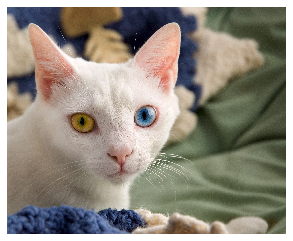

In [ ]:
im.show()

So what have we learned? Each item type needs a `create` and a `show` method. How does this relate to `ImageBlock`? 
> では、何を学んだのでしょうか？ 各項目タイプには、作成および表示メソッドが必要です。 これはImageBlockとどのように関係していますか？

In [ ]:
ImageBlock??

In [ ]:
def ImageBlock(cls=PILImage): return TransformBlock(type_tfms=cls.create, 
                                                    batch_tfms=IntToFloatTensor)

Now we're getting somewhere. If we want to use the `DataBlock`, each inherit from a `TransformBlock`
> 今、私たちはどこかに着いています。 `DataBlock`を使用する場合、それぞれが` TransformBlock`から継承します

In [ ]:
block = TransformBlock(type_tfms=PILImage.create, batch_tfms=IntToFloatTensor)

How would this convert over to a non-image? Let's look at a simple verion, points!
> これはどのように非画像に変換しますか？ 簡単なバージョン、ポイントを見てみましょう！

# Points

If we take a look at the `PointBlock` object, we see the following:
> `PointBlock`オブジェクトを見ると、次のことがわかります。
---



In [ ]:
PointBlock = TransformBlock(type_tfms=TensorPoint.create, item_tfms=PointScaler)

So let's break this down into two parts, the `TensorPoint` and the `PointScaler`
> では、これを `TensorPoint`と` PointScaler`の2つの部分に分けましょう。

## TensorPoint

The goal of the `TensorPoint` is to turn a list of points into a `tensor` that we can work with, that is **it**. Nothing about transforms, just generating some form of a **raw** input. Let's try building our own based on what we saw earlier, and then see how close we got to the source code
> `TensorPoint`の目標は、ポイントのリストを、操作できる`テンソル `、つまり**それ**に変えることです。 変換については何もせず、何らかの形式の**未加工**入力を生成するだけです。 先に見たものに基づいて独自のものを構築してみて、ソースコードにどれだけ近づいたかを見てみましょう

In [ ]:
class myTensorPoint(TensorBase):
    @classmethod
    def create(cls, t):
        return cls(tensor(t).view(-1,2).float())

Awesome. Let's try to improve it a bit more. We also want to be careful about our image size, as we may need it for when we transform our image, etc. So let's pass this to it
> 素晴らしい。 もう少し改善してみましょう。 また、画像を変換するときなどに必要になる可能性があるため、画像サイズにも注意したいので、これに渡します。

In [ ]:
class myTensorPoint(TensorBase):
    @classmethod
    def create(cls, t, img_size=None)->None:
        return cls(tensor(t).view(-1,2).float(), img_size=img_size)

Let's try it
> 試してみよう

In [ ]:
im.shape

(1927, 2370)

In [ ]:
pnts = [[1000,100], [200,300]]

In [ ]:
tps = myTensorPoint.create(pnts)

In [ ]:
tps

myTensorPoint([[1000.,  100.],
        [ 200.,  300.]])

Awesome. Now we need a `show` method. We'll use a scatter plot as we are dealing with points
> 素晴らしい。 次に、 `show`メソッドが必要です。 ポイントを扱っているので、散布図を使用します

In [ ]:
class myTensorPoint(TensorBase):
    _show_args = dict(s=10, marker='.', c='r')
    @classmethod
    def create(cls, t, img_size=None)->None:
        return cls(tensor(t).view(-1,2).float(), img_size=img_size)
  
    def show(self, ctx=None, **kwargs):
        if 'figsize' in kwargs: del kwargs['figsize']
        x = self.view(-1,2)
        ctx.scatter(x[:,0], x[:,1], **{**self._show_args, **kwargs})
        return ctx

Let's try this
> やってみよう

In [ ]:
tps = myTensorPoint.create(pnts)

In [ ]:
tps.show()

AttributeError: ignored

Hmmm. Why does this not work? Well we want to overlay it on our image! Let's try passing in an image too
> うーん。 なぜこれが機能しないのですか？ それを画像にオーバーレイしたいと思います！ 画像も渡してみましょう

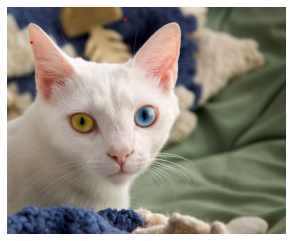

In [ ]:
ctx = im.show()
tps.show(ctx=ctx)

Now we see them!
> 今私たちはそれらを見ます！

Now there's a few other bits that we want to do. Let's first make our `myTensorPoint.create` into a `Tranform`, to allow for what's called `setups`, we will see more on this later
> 今、私たちがしたいいくつかの他のビットがあります。 まず、 `myTensorPoint.create`を` Tranform`にして、いわゆる`setups`を可能にします。これについては後で詳しく説明します

In [ ]:
Transform??

In [ ]:
myTensorPointCreate = Transform(myTensorPoint.create)

Any time we deal with these points, we want a loss function of `MSELossFlat`, lets do this by default (so `cnn_learner` knows which loss function to use!)
> これらのポイントを扱うときはいつでも、 `MSELossFlat`の損失関数が必要です。これをデフォルトで実行できます（これにより、` cnn_learner`は使用する損失関数を認識します！）

In [ ]:
myTensorPointCreate.loss_func = MSELossFlat()

And now let's replace our original `myTensorPoint`'s `create` function with this new one
> そして今、元の `myTensorPoint`の` create`関数をこの新しいものに置き換えましょう

In [ ]:
myTensorPoint.create = myTensorPointCreate

How close were we to the source code?
> 私たちはソースコードにどのくらい近づきましたか？

In [ ]:
class TensorPoint(TensorBase):
    "Basic type for points in an image"
    _show_args = dict(s=10, marker='.', c='r')

    @classmethod
    def create(cls, t, img_size=None)->None:
        "Convert an array or a list of points `t` to a `Tensor`"
        return cls(tensor(t).view(-1, 2).float(), img_size=img_size)

    def show(self, ctx=None, **kwargs):
        if 'figsize' in kwargs: del kwargs['figsize']
        x = self.view(-1,2)
        ctx.scatter(x[:, 0], x[:, 1], **{**self._show_args, **kwargs})
        return ctx

TensorPointCreate = Transform(TensorPoint.create)
TensorPointCreate.loss_func = MSELossFlat()
TensorPoint.create = TensorPointCreate

So now we have seen how to create an item type, and what is needed. Now how do I make sure I deal with the `transforms`? For instance with keypoints, I need to scale the image and warp it depending on the transforms (such as cropping)
> これで、アイテムタイプの作成方法と必要なものを見てきました。 では、どうすれば`transforms`を処理することができますか？ たとえばキーポイントの場合、画像をスケーリングし、変換に応じて（トリミングなど）ワープする必要があります

# PointScaler

What does the following code tell us about this?
> 次のコードはこれについて私たちに何を伝えますか？

In [ ]:
PointBlock = TransformBlock(type_tfms=TensorPoint.create, item_tfms=PointScaler)

`PointScaler` is an **item transform**, which means it occurs each time we call the particular item, not when it is turned into a batch. Which is what we need to have happen, as we crop our images during an item transform!
> `PointScaler`は**アイテムの変換**です。つまり、バッチに変換されたときではなく、特定のアイテムを呼び出すたびに発生します。 これは、アイテムの変換中に画像をトリミングするときに必要です。

Now how do we deal with this? Transforms have the following:
* `order` - when does it occur? The lower the value, the sooner it is done
* `setups` - When we prepare our data, such as our `data.c`?
* `encodes` - When we are transforming our image
* `decodes` - When we are decoding our image

> これをどのように処理するのでしょうか？ 変換には次のものがあります。
> * `order` - いつ発生しますか？ 値が低いほど、早く実行されます
> * `setups` - ` data.c`などのデータを準備するとき？
> * `encodes` - 画像を変換するとき
> * `decodes` - 画像をデコードするとき

Let's walk through the start of `PointScaler`. We want it to scale our points and possibly operate differently if we pass in `y` then `x` instead of `x,y`
> `PointScaler`の始まりを見てみましょう。 ポイントをスケーリングし、 `x、y`ではなく` y`を渡してから `x`を渡した場合に動作が異なるようにしたい

In [ ]:
class myPointScaler(Transform):
    order = 1 # Want this to occur first!
    def __init__(self, do_scale=True, y_first=False): 
        self.do_scale, self.y_first = do_scale, y_first

Now let's grab some `setups`. We want this to take the total available points in our dataset, we can use `.numel()` to do this
> 次に、いくつかの`setups`を取得します。 これはデータセットで利用可能な合計ポイントを取得したいので、 `.numel（）`を使用してこれを行うことができます

In [ ]:
tps.numel()

4

In [ ]:
class myPointScaler(Transform):
    order = 1 # Want this to occur first!
    def __init__(self, do_scale=True, y_first=False): 
        self.do_scale, self.y_first = do_scale, y_first

    def setups(self, dl):
        its = dl.do_item(0)
        for t in its:
            if isinstance(t, TensorPoint): self.c = t.numel()

Where do I go from here? `encodes` and `decodes` work by seeing if `x` follows a type, and if so we perform it. For our input, we want to see what the current size is of our points. Let's first make a method to get the size
> ここからどこへ行くのですか？ `encodes`と` decodes`は、 `x`が型の後に続くかどうかを確認することで機能します。 入力では、現在のサイズがポイントであるかどうかを確認します。 まずサイズを取得するメソッドを作ってみましょう

In [ ]:
class myPointScaler(Transform):
    order = 1 # Want this to occur first!
    def __init__(self, do_scale=True, y_first=False): 
        self.do_scale, self.y_first = do_scale, y_first

    def setups(self, dl):
        its = dl.do_item(0)
        for t in its:
            if isinstance(t, TensorPoint): self.c = t.numel()

    def _grab_sz(self, x):
        self.sz = [x.shape[-1], x.shape[-2]] if isinstance(x, Tensor) else x.size

Now let's make an encodes and decodes which just grabs the shape of our points **if** we have an image
> 次に、画像がある**場合に**ポイントの形状を取得するエンコードとデコードを作成しましょう。

In [ ]:
class myPointScaler(Transform):
    order = 1 # Want this to occur first!
    def __init__(self, do_scale=True, y_first=False): 
        self.do_scale, self.y_first = do_scale, y_first

    def setups(self, dl):
        its = dl.do_item(0)
        for t in its:
            if isinstance(t, TensorPoint): self.c = t.numel()

    def _grab_sz(self, x):
        self.sz = [x.shape[-1], x.shape[-2]] if isinstance(x, Tensor) else x.size

    def encodes(self, x:(PILBase, TensorImageBase)): return self._grab_sz(x)
    def decodes(self, x:(PILBase, TensorImageBase)): return self._grab_sz(x)

Now let's make a new one that should either scale or unscale our points based on a transformation. We'll make a simple `scale_pnts` function to scale them together
> 次に、変換に基づいてポイントをスケールまたはスケール解除する新しいものを作成しましょう。 それらを一緒にスケーリングする単純な `scale_pnts`関数を作成します

In [ ]:
def _myScale_pnts(y, sz, do_scale=True, y_first=False):
    if y_first: y = y.flip(1)
        res = y * 2/tensor(sz).float() -1 if do_scale else y
        return TensorPoint(res, img_sz=sz)

Does this work? Let's try
> これは機能しますか？ やってみよう

In [ ]:
tps

myTensorPoint([[1000.,  100.],
        [ 200.,  300.]])

In [ ]:
_myScale_pnts(tps, 224)

TensorPoint([[ 7.9286, -0.1071],
        [ 0.7857,  1.6786]])

What would a point at the end of an image look like?
> 画像の最後のポイントはどのように見えますか？

In [ ]:
im.shape

(1927, 2370)

In [ ]:
pnts = [[0,0], [2370,0], [0,1927], [2370, 1927]]

In [ ]:
tps = TensorPoint.create(pnts)

In [ ]:
tps

(TensorPoint([[0., 0.]]),
 TensorPoint([[2370.,    0.]]),
 TensorPoint([[   0., 1927.]]),
 TensorPoint([[2370., 1927.]]))

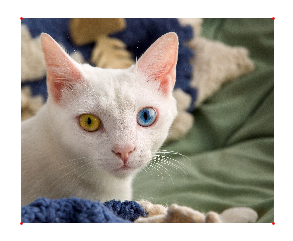

In [ ]:
ax = im.show()
for tp in tps: tp.show(ctx=ax)

In [ ]:
s_pnts = [_myScale_pnts(tp, 224) for tp in tps]

In [ ]:
s_pnts

[TensorPoint([[-1., -1.]]),
 TensorPoint([[20.1607, -1.0000]]),
 TensorPoint([[-1.0000, 16.2054]]),
 TensorPoint([[20.1607, 16.2054]])]

Next question: does this hold for other images and image sizes?
> 次の質問：これは他の画像や画像サイズにも当てはまりますか？

In [ ]:
url2 = 'https://geekologie.com/2019/08/28/crazy-maine-coon-cat.jpg'
download_url(url2, 'cat2.jpg')

In [ ]:
im2 = PILImage.create('cat2.jpg')

In [ ]:
im2.shape

(770, 640)

In [ ]:
pnts2 = [[0,0], [640,0], [0,770], [640, 770]]

In [ ]:
tps2 = TensorPoint.create(pnts2)

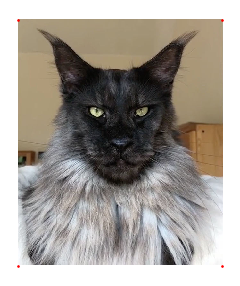

In [ ]:
ax = im2.show()
for tp in tps2: tp.show(ctx=ax)

In [ ]:
[_myScale_pnts(tp, 224) for tp in tps2]

[TensorPoint([[-1., -1.]]),
 TensorPoint([[ 4.7143, -1.0000]]),
 TensorPoint([[-1.0000,  5.8750]]),
 TensorPoint([[4.7143, 5.8750]])]

We can see that (0,0) is always `-1,-1`
> （0,0）は常に `-1、-1`であることがわかります

Now we need a way to undo this.
> これを元に戻す方法が必要です。

In [ ]:
def _myUnscale_pnts(y, sz): return TensorPoint((y+1)*tensor(sz).float()/2, img_size=sz)

In [ ]:
s_pnts

[TensorPoint([[-1., -1.]]),
 TensorPoint([[20.1607, -1.0000]]),
 TensorPoint([[-1.0000, 16.2054]]),
 TensorPoint([[20.1607, 16.2054]])]

We pass in what the tranformed size is, and we get back our original points
> 変換後のサイズを渡し、元のポイントを取り戻します

In [ ]:
[_myUnscale_pnts(tp, 224) for tp in s_pnts]

[TensorPoint([[0., 0.]]),
 TensorPoint([[2370.,    0.]]),
 TensorPoint([[   0., 1927.]]),
 TensorPoint([[2370., 1927.]])]

And that's it! We transform our points based on a new image size, and then have it be cropped, rotated, etc
> 以上です！ 新しい画像サイズに基づいてポイントを変換してから、トリミング、回転などを行います

In [ ]:
def _scale_pnts(y, sz, do_scale=True, y_first=False):
    if y_first: y = y.flip(1)
    res = y * 2/tensor(sz).float() - 1 if do_scale else y
    return TensorPoint(res, img_size=sz)

def _unscale_pnts(y, sz): return TensorPoint((y+1) * tensor(sz).float()/2, img_size=sz)

class PointScaler(Transform):
    "Scale a tensor representing points"
    order = 1
    def __init__(self, do_scale=True, y_first=False): self.do_scale,self.y_first = do_scale,y_first
    def _grab_sz(self, x):
        self.sz = [x.shape[-1], x.shape[-2]] if isinstance(x, Tensor) else x.size
        return x

    def _get_sz(self, x):
        sz = x.get_meta('img_size')
        assert sz is not None or self.sz is not None, "Size could not be inferred, pass it in the init of your TensorPoint with `img_size=...`"
        return self.sz if sz is None else sz

    def setups(self, dl):
        its = dl.do_item(0)
        for t in its:
            if isinstance(t, TensorPoint): self.c = t.numel()

    def encodes(self, x:(PILBase,TensorImageBase)): return self._grab_sz(x)
    def decodes(self, x:(PILBase,TensorImageBase)): return self._grab_sz(x)

    def encodes(self, x:TensorPoint): return _scale_pnts(x, self._get_sz(x), self.do_scale, self.y_first)
    def decodes(self, x:TensorPoint): return _unscale_pnts(x.view(-1, 2), self._get_sz(x))

Now how do we make a `Block` with our new bits?
> 次に、新しいビットで`ブロック`を作成するにはどうすればよいですか？

In [ ]:
myPointBlock = TransformBlock(type_tfms=myTensorPoint.create, item_tfms=myPointScaler)

From there, if we want to generate a transform, we `@patch` it. For example, `flip_lr`
> そこから、変換を生成したい場合は、それを`@patch`します。 たとえば、 `flip_lr`

In [ ]:
def _neg_axis(x, axis):
    x[...,axis] = -x[...,axis]
    return x

In [ ]:
@patch
def flip_lr(x:TensorPoint): return TensorPoint(_neg_axis(x.clone(), 0))